In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
try:
    os.chdir("drive/My Drive/PROJEKT/")
except FileNotFoundError:
    pass


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from matplotlib import pyplot as plt
import numpy as np
from definitions import *
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.cm as cm

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

#base_image_path = 'test_files/wasp/693_5311___0_5784.jpg'
#result_prefix = "deepdream/test/wasp693_5311___0_5784.jpg"
base_image_path = 'train_files/5501_5175___0_933.jpg'
result_prefix = 'deepdream/test/LOW35501_5175___0_933.jpg.jpg'


# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "block1_conv1":2,
    "block1_conv2":2,
    #"block5_conv3": 0.003,
    #"block5_conv4": 0.003,
}



# Playing with these hyperparameters will also allow you to achieve new effects
# step = 0.005  # Gradient ascent step size
# num_octave = 20  # Number of scales at which to run gradient ascent   wasp 30
# octave_scale = 1.1  # Size ratio between scales
# iterations = 100  # Number of ascent steps per scale
# max_loss = 100

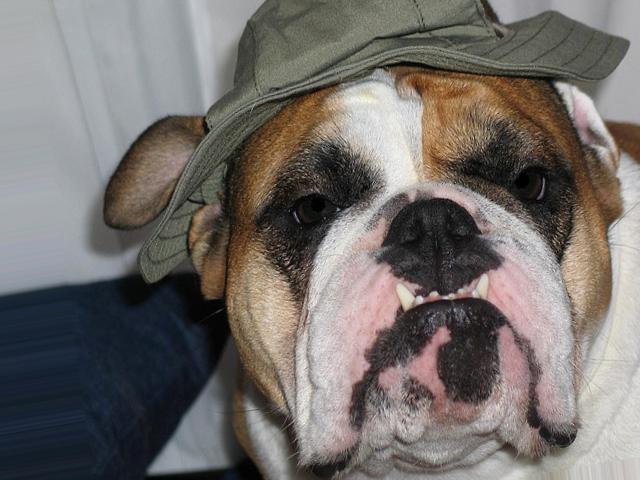

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))

In [ ]:

    
def postprocess_image(image):
    image[:, :, :, 0] += 103.939
    image[:, :, :, 1] += 116.779
    image[:, :, :, 2] += 123.68
    return np.clip(image[:, :, :, ::-1], 0, 255).astype('uint8')[0]

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #img = tf.image.resize(img, [ 224, 224])

    img = vgg19.preprocess_input(img)
    return img



In [ ]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)
model_path = 'models/task_2a_2e-52021-01-14_15-40-33_acc_0.9027.h5' #'models/task_2c2e-5.h5'
model_our = keras.models.load_model(model_path)
model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

outputs_dict_our = dict(
    [
        (layer.name, layer.output)
        for layer in [model_our.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor_our = keras.Model(inputs=model_our.inputs, outputs=outputs_dict_our)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
#feature_extractor.summary()

    

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Load weights from our model to loaded 
(to get rid of sizes)

In [ ]:
weights = feature_extractor_our.get_weights()
feature_extractor.set_weights(weights)
#feature_extractor.summary()

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [ ]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [ ]:
step = 0.1  # Gradient ascent step size
num_octave = 15 # Number of scales at which to run gradient ascent   wasp 30
octave_scale = 1.1  # Size ratio between scales
iterations = 150  # Number of ascent steps per scale
max_loss = None

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
print(original_shape)
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)


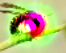

In [ ]:
keras.preprocessing.image.save_img(result_prefix + ".png", postprocess_image(img.numpy()))
display(Image(result_prefix + ".png"))